# Lorenz-63 model
In this Notebook we'll demonstrate how to construct multivariate models. To this end, we shall consider the Lorenz-63 model, defined as 
\begin{equation}
    \begin{cases}
        \mathrm{d}X^1_t = -S (X^1_t - X^2_t) \mathrm{d}t + \mathrm{d}W^1_t, \\
        \mathrm{d}X^2_t = (RX^1_t - X^2_t - X^1_t \cdot X^2_t) \mathrm{d}t + \mathrm{d}W^2_t, \\
        \mathrm{d}X^3_t = (X^1_t \cdot X^2_t - BX^3_t) \mathrm{d}t + \mathrm{d}W^3_t,
    \end{cases}
\end{equation}
where $\{W^i_t\}$ are 1-dimensional Wienere processes and $(S, R, B) \in \mathbb{R}^3$. We assume that we collect discrete observations of the above system via the following set of equations
\begin{equation}
    \begin{cases}
        Y^1_t = k_o X^1_t + V^1_t, \\
        Y^2_t = k_o X^3_t + V^2_t,
    \end{cases}
\end{equation}
where $k_o > 0$, and $V^i_t \sim \mathcal{N}(0, \sigma^2)$ where $\sigma^2 = 0.1$. We proceed in the same manner as the Stochastic volatility example and import the necessary packages.

In [8]:
from pyfilter.timeseries import StateSpaceModel, EulerMaruyma, LinearGaussianObservations

Next, we define the inital distributions as
\begin{equation}
X^1_0 \sim \mathcal{N}(-5.9162, 10), \quad X^2_0 \sim \mathcal{N}(-5.52332, 10), \quad X^3_0 \sim \mathcal{N}(24.5723, 10),
\end{equation}
which means that the model equations are given by

In [2]:
import torch
import math


def finit(s, r, b):
    return torch.tensor([-5.91652, -5.52332, 24.5723], device=s.device)


def ginit(s, r, b):
    return math.sqrt(10) * torch.ones(3, device=s.device)


def f(x, s, r, b):
    x1 = -s * (x[0] - x[1])
    x2 = r * x[0] - x[1] - x[0] * x[2]
    x3 = x[0] * x[1] - b * x[2]

    return x1, x2, x3


def g(x, s, r, b):
    return torch.ones(3, device=x.device)

For this example we'll simulate data, we do this by setting $(S, R, B) \triangleq (10, 28, 8/3)$ and run the below script

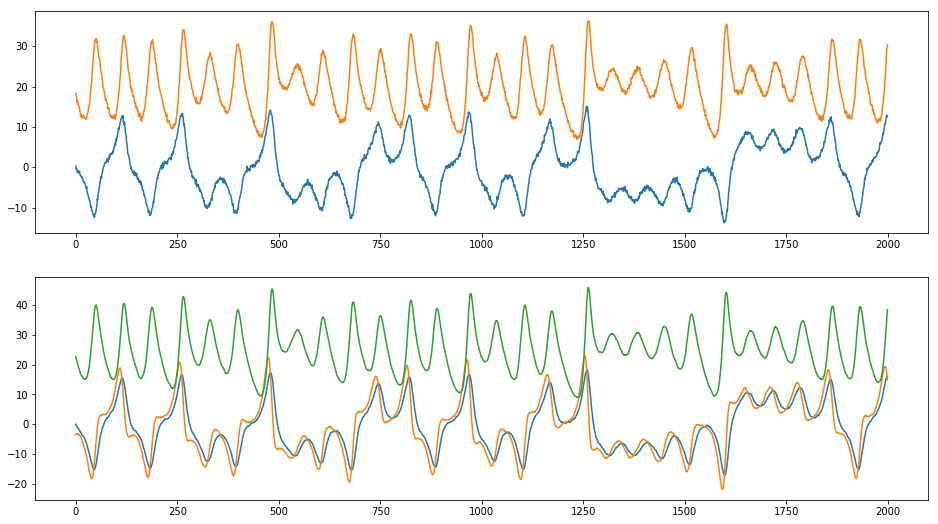

In [4]:
import matplotlib.pyplot as plt
from torch.distributions import Independent, Normal, Uniform, MultivariateNormal


dt = torch.tensor(1e-2)
hidden = EulerMaruyma((finit, ginit), (f, g), (10., 28., 8/3), ndim=3, dt=dt)

mat = torch.tensor([
    [0.8, 0., 0.],
    [0., 0., 0.8]
])

simmodel = LinearGaussianObservations(hidden, mat, torch.ones(2) / math.sqrt(10))

x, y = simmodel.sample(2000)

fig, ax = plt.subplots(2, figsize=(16, 9))

ax[1].plot(x.numpy())
ax[0].plot(y.numpy())

Where the upper plot is the observble data, and the lower is the hidden processes. Next, we shall perform the inference. We use the NESS to target the parameters. However, since the model has purely additive noise (rather than multiplicative) in the observational process, we may use the `Unscented Kalman Filter` to target the latent process. Furthermore, we use the same priors as in the original paper describing the NESS algorithm. Such that we get

In [6]:
from pyfilter.algorithms import NESS
from pyfilter.filters import UKF

hidden = EulerMaruyma((finit, ginit), (f, g), (Uniform(5, 40), Uniform(10, 50), Uniform(1, 20)), ndim=3, dt=dt)
ssm = LinearGaussianObservations(hidden, mat, torch.ones(2) / math.sqrt(10))

algs = list()
for i in range(2):
    filt_ = UKF(ssm.copy())
    alg = NESS(filt_, 2000)
    
    alg.initialize().fit(y)
    algs.append(alg)

NESS: 100%|████████████████████████████████████████████████████████████████████████| 2000/2000 [02:05<00:00, 15.94it/s]


And finally we plot the posterior distributions together with the true parameters

Run 1
	 Posterior mean and std: 10.13, 0.26
	 Posterior mean and std: 27.94, 0.12
	 Posterior mean and std: 2.65, 0.05
Run 2
	 Posterior mean and std: 10.06, 0.26
	 Posterior mean and std: 27.93, 0.13
	 Posterior mean and std: 2.64, 0.05


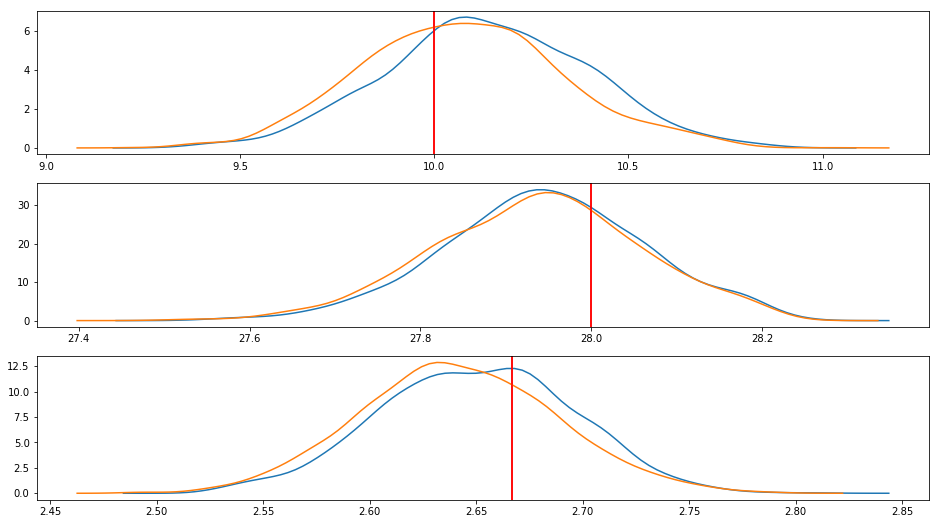

In [7]:
from pyfilter.utils import normalize

fig, ax = plt.subplots(3, figsize=(16, 9))

for r, alg in enumerate(algs):
    
    print('Run {:d}'.format(1 + r))

    for i, (p, ptrue) in enumerate(zip(alg.filter.ssm.hidden.theta, simmodel.hidden.theta)):
        weights = normalize(alg._w_rec)
        xrange, xvals = p.get_plottable(weights=weights)
        
        ax[i].plot(xrange, xvals)
        ax[i].axvline(ptrue.values, color='r')
        
        print('\t Posterior mean and std: {:.2f}, {:.2f}'.format(p.values.mean(), p.values.std()))

plt.show()